In [ ]:
#!/usr/bin/env python3
import os
import cv2
import time
import numpy as np
from functools import lru_cache
from urllib.request import urlopen
from PIL import Image
import onnx
import onnxruntime
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.colors import hsv_to_rgb

# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import files
    from google.colab.patches import cv2_imshow
# ─── Download Model if needed ────────────────────────────────────────────────
onnx_model_url = "https://github.com/Star-Clouds/CenterFace/raw/master/models/onnx/centerface.onnx"
default_onnx_path = 'centerface.onnx'

if not os.path.exists(default_onnx_path):
    print(f"Downloading {default_onnx_path} from {onnx_model_url}...")
    try:
        with urlopen(onnx_model_url) as response, open(default_onnx_path, 'wb') as out_file:
            data = response.read() # a `bytes` object
            out_file.write(data)
        print("Model downloaded successfully.")
    except Exception as e:
        print(f"Error downloading model: {e}")
        print("Please ensure the model file 'centerface.onnx' is available.")


try:
    base_dir = os.path.dirname(__file__)
except NameError:
    base_dir = os.getcwd()


def ensure_rgb(img: np.ndarray) -> np.ndarray:
    if img.ndim == 2:

        return cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    if img.shape[2] == 4:

        return cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)

    return img

class CenterFace:
    def __init__(self, onnx_path=None, in_shape=None, override_execution_provider=None):
        self.in_shape = in_shape
        self.onnx_input_name = 'input.1'
        self.onnx_output_names = ['537','538','539','540']
        if onnx_path is None:
            onnx_path = default_onnx_path
        if not os.path.exists(onnx_path):
             raise FileNotFoundError(f"ONNX model not found at {onnx_path}")

        static_model = onnx.load(onnx_path)
        dyn_model = self.dynamicize_shapes(static_model)

        providers = onnxruntime.get_available_providers()
        if override_execution_provider:
            if override_execution_provider not in providers:
                raise ValueError(f"{override_execution_provider=} not available, got {providers}")
            providers = [override_execution_provider]

        preferred_providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']
        available_preferred = [p for p in preferred_providers if p in providers]
        if not override_execution_provider and available_preferred:
             providers = [available_preferred[0]]

        self.sess = onnxruntime.InferenceSession(dyn_model.SerializeToString(), providers=providers)
        print(f"CenterFace running on {self.sess.get_providers()[0]}")


    @staticmethod
    def dynamicize_shapes(static_model):
        from onnx.tools.update_model_dims import update_inputs_outputs_dims
        inp_dims, out_dims = {}, {}
        for node in static_model.graph.input:
            inp_dims[node.name] = [d.dim_value for d in node.type.tensor_type.shape.dim]
        for node in static_model.graph.output:
            out_dims[node.name] = [d.dim_value for d in node.type.tensor_type.shape.dim]
        inp_dims['input.1'] = ['B',3,'H','W']
        out_dims.update({
            '537': ['B',1,'h','w'],
            '538': ['B',2,'h','w'],
            '539': ['B',2,'h','w'],
            '540': ['B',10,'h','w'],
        })
        return update_inputs_outputs_dims(static_model, inp_dims, out_dims)

    @staticmethod
    @lru_cache(maxsize=8)
    def shape_transform(in_shape, orig_shape):
        h0, w0 = orig_shape

        if in_shape is None:
            w1, h1 = w0, h0
        else:
            w1, h1 = in_shape


        w1 = int(np.ceil(w1/32)*32)
        h1 = int(np.ceil(h1/32)*32)


        sw = w1 / w0
        sh = h1 / h0
        return w1, h1, sw, sh

    def __call__(self, img: np.ndarray, threshold=0.5):

        img = ensure_rgb(img)
        orig_shape = img.shape[:2]

        target_shape_wh = orig_shape[::-1] if self.in_shape is None else self.in_shape
        w1, h1, sw, sh = self.shape_transform(target_shape_wh, orig_shape)
        blob = cv2.dnn.blobFromImage(img, 1.0, (w1,h1), (0,0,0), swapRB=False, crop=False)
        heatmap, scale, offset, lms = self.sess.run(self.onnx_output_names, {self.onnx_input_name: blob})
        dets, decoded_lms = self.decode(heatmap, scale, offset, lms, (h1,w1), threshold)

        if dets.shape[0] > 0:
            dets[:, 0:4:2] = np.clip(dets[:, 0:4:2], 0, w1)
            dets[:, 1:4:2] = np.clip(dets[:, 1:4:2], 0, h1)
            decoded_lms[:, 0:10:2] = np.clip(decoded_lms[:, 0:10:2], 0, w1)
            decoded_lms[:, 1:10:2] = np.clip(decoded_lms[:, 1:10:2], 0, h1)

            dets[:, 0:4:2] /= sw
            dets[:, 1:4:2] /= sh
            decoded_lms[:, 0:10:2] /= sw
            decoded_lms[:, 1:10:2] /= sh

            h0, w0 = orig_shape
            dets[:, 0:4:2] = np.clip(dets[:, 0:4:2], 0, w0)
            dets[:, 1:4:2] = np.clip(dets[:, 1:4:2], 0, h0)
            decoded_lms[:, 0:10:2] = np.clip(decoded_lms[:, 0:10:2], 0, w0)
            decoded_lms[:, 1:10:2] = np.clip(decoded_lms[:, 1:10:2], 0, h0)

        return dets, decoded_lms


    def decode(self, heatmap, scale, offset, landmark, size, threshold=0.5):
        heatmap = np.squeeze(heatmap)
        s0_map, s1_map = scale[0,0], scale[0,1]
        o0_map, o1_map = offset[0,0], offset[0,1]
        lm_map = landmark[0]
        stride = 4
        h_out, w_out = heatmap.shape
        size_h, size_w = size

        ys, xs = np.where(heatmap > threshold)
        boxes, lm_list = [], []

        for y, x in zip(ys, xs):
            score = heatmap[y, x]

            cx_feat = x + o1_map[y, x]
            cy_feat = y + o0_map[y, x]

            box_h = np.exp(s0_map[y, x]) * stride
            box_w = np.exp(s1_map[y, x]) * stride


            x1 = max(0, cx_feat * stride - box_w / 2)
            y1 = max(0, cy_feat * stride - box_h / 2)
            x2 = min(x1 + box_w, size_w)
            y2 = min(y1 + box_h, size_h)

            boxes.append([x1, y1, x2, y2, score])


            lm = []
            for j in range(5):
                lm_x = lm_map[j * 2 + 1, y, x] * box_w + x1
                lm_y = lm_map[j * 2,     y, x] * box_h + y1
                lm.append(lm_x)
                lm.append(lm_y)
            lm_list.append(lm)

        if not boxes:
            return np.zeros((0,5),dtype=np.float32), np.zeros((0,10),dtype=np.float32)

        boxes = np.array(boxes, dtype=np.float32)
        lms   = np.array(lm_list, dtype=np.float32)
        keep  = self.nms(boxes[:,:4], boxes[:,4], 0.3)
        return boxes[keep], lms[keep]

    @staticmethod
    def nms(boxes, scores, thresh):
        x1, y1, x2, y2 = boxes.T
        areas = (x2 - x1) * (y2 - y1)
        order = scores.argsort()[::-1]
        keep = []
        while order.size > 0:
            i = order[0]
            keep.append(i)
            xx1 = np.maximum(x1[i], x1[order[1:]])
            yy1 = np.maximum(y1[i], y1[order[1:]])
            xx2 = np.minimum(x2[i], x2[order[1:]])
            yy2 = np.minimum(y2[i], y2[order[1:]])
            inter_w = np.maximum(0.0, xx2 - xx1)
            inter_h = np.maximum(0.0, yy2 - yy1)
            inter = inter_w * inter_h
            iou = inter / (areas[i] + areas[order[1:]] - inter + 1e-6)
            inds = np.where(iou <= thresh)[0]
            order = order[inds + 1]
        return keep


# ─── CLAHE(Contrast Limited Adaptive Histogram Equalization) Preprocessing ─────────────────────────────────
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
def apply_clahe(frame: np.ndarray) -> np.ndarray:
    frame_bgr = ensure_rgb(frame)
    try:
        lab = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        l2 = clahe.apply(l)
        lab2 = cv2.merge((l2, a, b))
        return cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)
    except cv2.error as e:
        print(f"CLAHE Error: {e}. Skipping CLAHE for this frame.")
        return frame_bgr


# ─── Adaptive Blurring Utility ────────────────────────────────────────
def apply_blur(roi, blur_mode="auto", gaussian_ksize=25, mosaic_size=10):
    if roi is None or roi.shape[0] == 0 or roi.shape[1] == 0:
        return roi

    h, w = roi.shape[:2]
    area = h * w
    if area == 0: return roi

    if blur_mode == "auto":
        blur_mode = "mosaic" if area > 10000 else "gaussian"

    if blur_mode == "gaussian":
        ksize = gaussian_ksize if gaussian_ksize % 2 != 0 else gaussian_ksize + 1
        ksize = min(ksize, w // 2 * 2 + 1, h // 2 * 2 + 1)
        if ksize < 3:
           ksize = 3
        if w < ksize or h < ksize :
             blur_mode = "mosaic"
        else:
             return cv2.GaussianBlur(roi, (ksize, ksize), 0)

    m_size = max(1, mosaic_size)
    target_w = max(1, w // m_size)
    target_h = max(1, h // m_size)
    small = cv2.resize(roi, (target_w, target_h), interpolation=cv2.INTER_LINEAR)
    return cv2.resize(small, (w, h), interpolation=cv2.INTER_NEAREST)


# ─── Instantiate detectors & globals ─────────────────────
try:
    centerface = CenterFace()
except Exception as e:
    print(f"Error initializing CenterFace: {e}")
    print("Face detection might not work.")
    centerface = None

orb = cv2.ORB_create(nfeatures=500)
min_orb_kp = 15
min_inliers = 4
alpha = 0.6


def process_frame(frame, centerface_detector, orb_detector, prev_boxes, prev_lms,
                  apply_temporal_smoothing=True, use_orb=True, use_ransac=True):
    if centerface_detector is None:
        print("CenterFace detector not initialized. Skipping frame processing.")
        return frame

    processed_frame = frame.copy()
    h, w = processed_frame.shape[:2]


    enhanced = apply_clahe(processed_frame)


    dets, lms_raw = centerface_detector(enhanced)


    boxes = []
    for x1, y1, x2, y2, score in dets:

        x1, y1 = int(max(0, x1)), int(max(0, y1))
        x2, y2 = int(min(w, x2)), int(min(h, y2))
        ww, hh = x2 - x1, y2 - y1
        if ww > 0 and hh > 0:
            boxes.append((x1, y1, ww, hh))


    lms = [lms_raw[i] for i in range(len(boxes))]


    valid_indices = list(range(len(boxes)))


    if use_orb and len(boxes) > 0:
        gray = cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY)
        orb_valid = []
        for i in valid_indices:
            x, y, ww, hh = boxes[i]

            roi_y_end = min(y + hh, h)
            roi_x_end = min(x + ww, w)
            if y < roi_y_end and x < roi_x_end :
                 roi = gray[y:roi_y_end, x:roi_x_end]
                 if roi.size > 0:
                    kps = orb_detector.detect(roi, None)
                    if len(kps) >= min_orb_kp:
                        orb_valid.append(i)
            else:
                 pass


        if len(orb_valid) > 0 or len(boxes) == 0:
            valid_indices = orb_valid


    if use_ransac and apply_temporal_smoothing and prev_lms and len(prev_lms) == len(valid_indices) and len(valid_indices) > 0:
        ransac_valid = []
        current_lms_filtered = [lms[i] for i in valid_indices]
        if len(prev_lms) == len(current_lms_filtered):
            for idx, current_lm_idx in enumerate(valid_indices):
                try:
                    prev_pts = np.array(prev_lms[idx]).reshape(-1, 2).astype(np.float32)
                    curr_pts = np.array(current_lms_filtered[idx]).reshape(-1, 2).astype(np.float32)

                    if prev_pts.shape[0] >= 2 and curr_pts.shape[0] == prev_pts.shape[0]:
                        M, inliers = cv2.estimateAffinePartial2D(prev_pts, curr_pts,
                                                                 method=cv2.RANSAC,
                                                                 ransacReprojThreshold=5.0)
                        if M is not None and inliers is not None and inliers.sum() >= min_inliers:
                            ransac_valid.append(current_lm_idx)
                    else:
                         pass

                except Exception as e:
                     print(f"RANSAC Error on index {idx}: {e}")
                     pass


            if len(ransac_valid) > 0 or len(valid_indices) == 0 :
                 valid_indices = ransac_valid

        else:
             pass

    final_boxes = [boxes[i] for i in valid_indices]
    final_lms = [lms[i] for i in valid_indices]


    smoothed_boxes = []
    if apply_temporal_smoothing and prev_boxes and final_boxes:
        matched_prev_indices = set()
        for i, b in enumerate(final_boxes):
            best_iou = 0.0
            best_prev_idx = -1
            for j, pb in enumerate(prev_boxes):
                 if j in matched_prev_indices: continue

                 xa = max(b[0], pb[0]); ya = max(b[1], pb[1])
                 xb = min(b[0]+b[2], pb[0]+pb[2]); yb = min(b[1]+b[3], pb[1]+pb[3])
                 inter = max(0, xb-xa) * max(0, yb-ya)
                 union = b[2]*b[3] + pb[2]*pb[3] - inter
                 iou = inter / (union + 1e-6)

                 if iou > best_iou and iou > 0.1:
                     best_iou = iou
                     best_prev_idx = j

            if best_prev_idx != -1:

                pb = prev_boxes[best_prev_idx]
                x = int(alpha * pb[0] + (1 - alpha) * b[0])
                y = int(alpha * pb[1] + (1 - alpha) * b[1])
                w2 = int(alpha * pb[2] + (1 - alpha) * b[2])
                h2 = int(alpha * pb[3] + (1 - alpha) * b[3])
                smoothed_boxes.append((x, y, w2, h2))
                matched_prev_indices.add(best_prev_idx)
            else:

                smoothed_boxes.append(b)
    else:

        smoothed_boxes = final_boxes

    for (x, y, ww, hh) in smoothed_boxes:
        y_end = min(y + hh, h)
        x_end = min(x + ww, w)
        if y < y_end and x < x_end:
            roi = processed_frame[y:y_end, x:x_end]
            if roi.size > 0:
                blurred_roi = apply_blur(roi, blur_mode="auto")
                processed_frame[y:y_end, x:x_end] = blurred_roi

        else:
             print(f"Skipping invalid ROI slice: x={x}, y={y}, w={ww}, h={hh} -> x_end={x_end}, y_end={y_end}")


    prev_boxes.clear()
    prev_boxes.extend(smoothed_boxes)
    prev_lms.clear()
    prev_lms.extend(final_lms)
    return processed_frame


def blur_faces_in_image(image_path, output_path=None, display=True):
    print(f"Processing image: {image_path}")
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image file: {image_path}")
        return

    processed_img = process_frame(
        img, centerface, orb, [], [],
        apply_temporal_smoothing=False,
        use_orb=False,
        use_ransac=False
    )

    if output_path:
        try:
            cv2.imwrite(output_path, processed_img)
            print(f"Blurred image saved to: {output_path}")
        except Exception as e:
            print(f"Error saving image to {output_path}: {e}")

    if display:
        orig_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        proc_rgb = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)

        fig, axes = plt.subplots(1, 2, figsize=(15, 7))
        axes[0].imshow(orig_rgb)
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        axes[1].imshow(proc_rgb)
        axes[1].set_title(f"Blurred Faces: {os.path.basename(image_path)}")
        axes[1].axis("off")

        plt.tight_layout()
        plt.show()

    elif IN_COLAB and not display:
        print("Displaying with Colab's cv2_imshow (may differ from matplotlib).")
        from google.colab.patches import cv2_imshow
        cv2_imshow(processed_img)


# ─── Function for Blurring Video File ───────────────────────────────────────
def blur_faces_in_video(input_video_path, output_video_path):

    print(f"Processing video: {input_video_path}")
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print(f"Error: Cannot open video file: {input_video_path}")
        return

    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Video properties: {w}x{h} @ {fps:.2f} FPS, {frame_count} frames")

    if w == 0 or h == 0:
         print("Error: Video width or height is zero. Cannot process.")
         cap.release()
         return

    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Or 'XVID' for .avi
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (w, h))
    if not out.isOpened():
         print(f"Error: Could not open video writer for path: {output_video_path}")
         print("Check if the codec 'mp4v' is supported and directory exists.")
         cap.release()
         return

    prev_boxes_vid = []
    prev_lms_vid = []

    with tqdm(total=frame_count, desc="Blurring Video Frames") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            processed_frame = process_frame(frame, centerface, orb,
                                            prev_boxes_vid, prev_lms_vid,
                                            apply_temporal_smoothing=True,
                                            use_orb=True,
                                            use_ransac=True)

            out.write(processed_frame)
            pbar.update(1)

    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"Finished processing. Blurred video saved to: {output_video_path}")



def blur_faces_in_webcam_and_record(save_path="webcam_output.mp4"):

    print("Starting webcam processing...")
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Cannot open webcam.")
        return

    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps <= 0 or fps > 100:
         print(f"Warning: Unusual FPS reported ({fps}). Using 30 FPS instead.")
         fps = 30.0

    print(f"Webcam properties: {w}x{h} @ {fps:.2f} FPS")

    if w == 0 or h == 0:
         print("Error: Webcam width or height is zero. Cannot process.")
         cap.release()
         return

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(save_path, fourcc, fps, (w, h))
    if not out.isOpened():
         print(f"Error: Could not open video writer for path: {save_path}")
         cap.release()
         return

    prev_boxes_webcam = []
    prev_lms_webcam = []
    prev_time = time.time()

    print("Processing webcam feed. Press 'q' in the display window to quit.")
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: Failed to capture frame from webcam.")
            break

        processed_frame = process_frame(frame, centerface, orb,
                                        prev_boxes_webcam, prev_lms_webcam,
                                        apply_temporal_smoothing=True,
                                        use_orb=True, use_ransac=True)

        now = time.time()
        fps_val = 1.0 / (now - prev_time) if (now - prev_time) > 0 else 0
        prev_time = now
        cv2.putText(processed_frame, f"FPS: {fps_val:.1f}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        try:
            if IN_COLAB:
                 pass
            else:
                 cv2.imshow("Privacy-Preserving Face Anonymization (Webcam)", processed_frame)
        except Exception as e:
             print(f"Display Error: {e}. Maybe cannot display in this environment.")

        out.write(processed_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("Quit signal received.")
            break
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"Webcam recording stopped. Output saved to: {save_path}")




CenterFace running on CPUExecutionProvider


## In case you have a video file, you can use the below commented blur_faces_in_video function

In [ ]:
#  3. Webcam Processing
blur_faces_in_webcam_and_record("webcam_blurred_output.mp4") # Output Video is in the webcam_blurred_output.mp4 file

# In case you have a video file
#input_video_path = "path/to/your/video.mp4"
#output_video_path = "path/to/your/blurred_video.mp4"
#if os.path.exists(input_video_path):
#   blur_faces_in_video(input_video_path, output_video_path)
#else:
#   print(f"Video file not found at: {input_video_path}")

Starting webcam processing...
Webcam properties: 640x480 @ 30.00 FPS
Processing webcam feed. Press 'q' in the display window to quit.
Quit signal received.
Webcam recording stopped. Output saved to: webcam_blurred_output.mp4


Processing image: C:\Users\saket\Desktop\VSCODE\Face-detection-project\22_Picnic_Picnic_22_183.jpg
Blurred image saved to: Face-detection-project\blurred_image.jpg


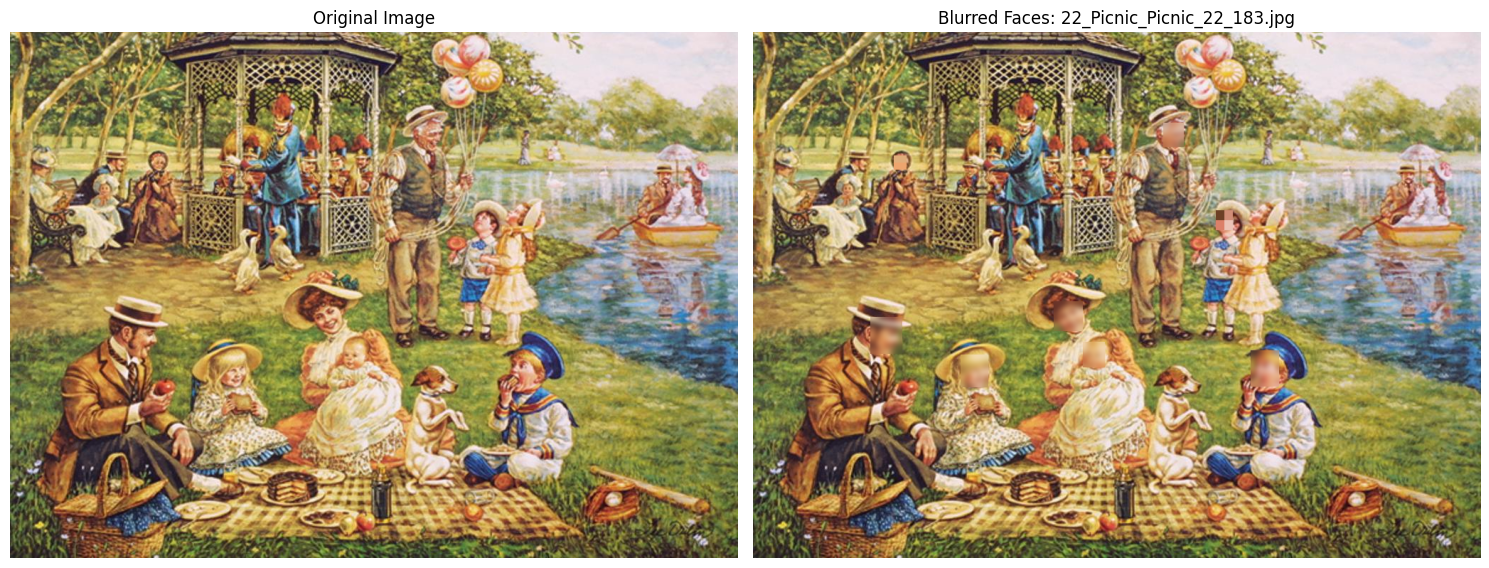

In [ ]:
# --- 1. Image Processing ---
input_image_path = r"C:\Users\saket\Desktop\VSCODE\Face-detection-project\22_Picnic_Picnic_22_183.jpg"
output_image_path = r"Face-detection-project\blurred_image.jpg"
if os.path.exists(input_image_path):
    blur_faces_in_image(input_image_path, output_image_path, display=True)
else:
    print(f"Image file not found at: {input_image_path}")